# Model Evaluation: XGBoost vs. GNNs

This notebook evaluates the performance of the trained XGBoost baseline model and selected Graph Neural Network (GNN) models on the held-out **test set**.

**Steps:**
1.  **Setup:** Load libraries and configuration.
2.  **Load Data & Processors:** Load the preprocessed test data splits and the fitted processors.
3.  **Define Evaluation Functions:** Create helper functions for calculating and plotting metrics.
4.  **Evaluate XGBoost Baseline:** Load the model and evaluate.
5.  **Evaluate GNN Models:** Specify GNN run directories, load configurations and models, pre-calculate features if needed, evaluate each.
6.  **Compare Results:** Summarize key metrics (AUC, AP, F1-score) in a table.

## 1. Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import pickle
import joblib
import json
from pathlib import Path
import time

import torch
import torch.nn.functional as F
import xgboost as xgb
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, average_precision_score, f1_score
from torch_geometric.data import Data, HeteroData

#  Configuration 
# Adjust path to go up one level from /notebooks to project root
project_root = Path(os.getcwd()).parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
print(f"Project Root: {project_root}")

# Attempt to import config from the src directory
try:
    import src.config as config
    from src.gnn_model import FraudGNN # Import model definition
    # Import conversion helper if needed for homo models
    from scripts.train_gnn import convert_to_homogeneous # Assumes it's in train_gnn or moved to utils
    print("Successfully imported src.config and models")
except ModuleNotFoundError as e:
    print(f"Error importing project modules: {e}. Make sure paths are correct and __init__.py exists if needed.")
    # Define essential variables manually if config fails
    config = type('obj', (object,), {
        'PROCESSED_DATA_PATH': os.path.join(project_root, "data", "processed", "processed_data.pkl"),
        'PROCESSORS_PATH': os.path.join(project_root, "data", "processed", "processors.joblib"),
        'XGB_MODEL_PATH': os.path.join(project_root, "models", "xgboost_model.json"),
        'MODEL_DIR': os.path.join(project_root, "models"),
        'TARGET_COL': 'isFraud',
        # Add other necessary config defaults if import fails
    })()
    print("Using manually defined config variables.")

#  Plotting Style 
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.1)

#  Device Setup 
device_str = 'cpu' # Default to CPU for evaluation unless GPU needed
if torch.cuda.is_available():
    device = torch.device('cuda')
# elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
#     device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")

#  Specify Model Runs to Evaluate 
# Add the paths to the specific run directories I want to compare
xgb_model_path = config.XGB_MODEL_PATH
gnn_run_dirs = [
    # Example: Replace with my actual run directory names
    os.path.join(config.MODEL_DIR, "20250330_162353_homo_SAGE_h128_l3"),
    os.path.join(config.MODEL_DIR, "20250330_162733_hetero_RGCN_h128_l2"),
    os.path.join(config.MODEL_DIR, "20250330_163731_hetero_SAGE_h32_l1"),
    # Add more run directories here
]

# Filter out directories that don't exist
gnn_run_dirs = [d for d in gnn_run_dirs if os.path.isdir(d)]
print(f"Found {len(gnn_run_dirs)} GNN run directories to evaluate.")

Project Root: /Users/aca/UoL/final/fdgnn
2.6.1
Successfully imported src.config and models
Using device: cpu
Found 3 GNN run directories to evaluate.


## 2. Load Data & Processors

In [2]:
print(f"Loading processed data from: {config.PROCESSED_DATA_PATH}")
try:
    with open(config.PROCESSED_DATA_PATH, 'rb') as f:
        processed_data = pickle.load(f)
except FileNotFoundError:
    print(f"Error: Processed data file not found at {config.PROCESSED_DATA_PATH}")
    # Stop execution or handle error
    raise

print(f"Loading processors from: {config.PROCESSORS_PATH}")
try:
    processors = joblib.load(config.PROCESSORS_PATH)
except FileNotFoundError:
    print(f"Error: Processors file not found at {config.PROCESSORS_PATH}")
    raise

# Import the custom dataset class
try:
    from src.gnn_dataset import IeeeFraudDetectionDataset
    print("Successfully imported IeeeFraudDetectionDataset")
except ModuleNotFoundError as e:
    print(f"Error importing dataset class: {e}")
    raise

# Extract necessary data components
X_test_xgb = processed_data.get('test', {}).get('xgb')
y_test = processed_data.get('test', {}).get('y')
test_indices = processed_data.get('test', {}).get('index') # Original indices of test set

# Load original HeteroData for GNN evaluation (needed for structure and original labels/masks)
# Assuming IeeeFraudDetectionDataset loads the graph correctly
print("Loading graph data via Dataset class...")
try:
    dataset_root = os.path.dirname(config.PROCESSED_DATA_DIR)
    dataset = IeeeFraudDetectionDataset(
        root=dataset_root,
        processed_data_path=config.PROCESSED_DATA_PATH,
        processors_path=config.PROCESSORS_PATH,
        force_process=False # Don't re-process if graph file exists
    )
    hetero_data_full = dataset[0].to(device) # Load the full graph
    print("Graph data loaded successfully.")
except Exception as e:
    print(f"Error loading graph data: {e}")
    hetero_data_full = None # Set to None if loading fails

# Basic checks
if X_test_xgb is None or y_test is None or test_indices is None:
    raise ValueError("Test data (XGBoost features, labels, or indices) not found in processed data.")
if hetero_data_full is None:
    raise ValueError("Failed to load graph data for GNN evaluation.")

print(f"XGBoost Test Features Shape: {X_test_xgb.shape}")
print(f"Test Labels Shape: {y_test.shape}")
print(f"Loaded HeteroData object:\n{hetero_data_full}")

Loading processed data from: /Users/aca/UoL/final/fdgnn/data/processed/processed_data.pkl
Loading processors from: /Users/aca/UoL/final/fdgnn/data/processed/processors.joblib
Successfully imported IeeeFraudDetectionDataset
Loading graph data via Dataset class...
Loading preprocessed data and processors for dataset setup...
Processed graph file found at '/Users/aca/UoL/final/fdgnn/data/processed/graph_data.pt'. Loading...
Graph data loaded successfully.
Graph data loaded successfully.
XGBoost Test Features Shape: (20000, 157)
Test Labels Shape: (20000,)
Loaded HeteroData object:
HeteroData(
  transaction={
    x_num=[100000, 87],
    x_cat=[100000, 23],
    y=[100000],
    num_nodes=100000,
    train_mask=[100000],
    val_mask=[100000],
    test_mask=[100000],
  },
  card_id={
    num_nodes=56098,
    x=[56098, 1],
  },
  device_profile_id={
    num_nodes=2754,
    x=[2754, 1],
  },
  network_profile_id={
    num_nodes=1698,
    x=[1698, 1],
  },
  locality_id={
    num_nodes=295,
    

## 3. Define Evaluation Functions

In [ ]:
def calculate_metrics(y_true, y_pred_proba, model_name="Model"):
    """Calculates and prints standard classification metrics."""
    y_pred_class = (y_pred_proba > 0.5).astype(int)

    results = {}
    print(f"\n Evaluation Results: {model_name} ")
    try:
        if len(np.unique(y_true)) > 1:
            auc = roc_auc_score(y_true, y_pred_proba)
            ap = average_precision_score(y_true, y_pred_proba)
            print(f"Test AUC: {auc:.4f}")
            print(f"Test Average Precision (AP): {ap:.4f}")
            results['AUC'] = auc
            results['AP'] = ap
        else:
            print("Warning: Only one class present in test set. AUC/AP cannot be calculated reliably.")
            results['AUC'] = float('nan')
            results['AP'] = float('nan')

        report = classification_report(y_true, y_pred_class, target_names=['Not Fraud', 'Fraud'], zero_division=0, output_dict=True)
        cm = confusion_matrix(y_true, y_pred_class)

        print("\nClassification Report:")
        # Pretty print the report dictionary
        print(pd.DataFrame(report).transpose().to_string())
        # Store key metrics like F1-scores
        results['F1_Fraud'] = report.get('Fraud', {}).get('f1-score', 0.0)
        results['F1_Macro'] = report.get('macro avg', {}).get('f1-score', 0.0)
        results['Precision_Fraud'] = report.get('Fraud', {}).get('precision', 0.0)
        results['Recall_Fraud'] = report.get('Fraud', {}).get('recall', 0.0)

        print("\nConfusion Matrix:")
        if cm.shape == (2, 2):
            print(f"   TN: {cm[0][0]:<6}  FP: {cm[0][1]:<6}")
            print(f"   FN: {cm[1][0]:<6}  TP: {cm[1][1]:<6}")
            results['TN'] = cm[0][0]
            results['FP'] = cm[0][1]
            results['FN'] = cm[1][0]
            results['TP'] = cm[1][1]
        else:
             print(cm)
        print("--------------------------------------")
        return results, cm

    except Exception as e:
        print(f"Error calculating metrics: {e}")
        return {}, None

def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
    """Plots a confusion matrix using seaborn."""
    if cm is None or cm.shape != (2, 2):
        print("Cannot plot confusion matrix.")
        return
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    plt.figure(figsize=(6, 5))
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
    except ValueError:
        heatmap = sns.heatmap(df_cm, annot=False, fmt="d", cmap="Blues")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)
    plt.tight_layout()
    plt.show()

## 4. Evaluate XGBoost Baseline

Loading XGBoost model from: /Users/aca/UoL/final/fdgnn/models/xgboost_model.json
Making XGBoost predictions on test set...

--- Evaluation Results: XGBoost Baseline ---
Test AUC: 0.8735
Test Average Precision (AP): 0.3487

Classification Report:
              precision    recall  f1-score      support
Not Fraud      0.989222  0.997511  0.993349  19690.00000
Fraud          0.662069  0.309677  0.421978    310.00000
accuracy       0.986850  0.986850  0.986850      0.98685
macro avg      0.825645  0.653594  0.707664  20000.00000
weighted avg   0.984151  0.986850  0.984493  20000.00000

Confusion Matrix:
   TN: 19641   FP: 49    
   FN: 214     TP: 96    
--------------------------------------


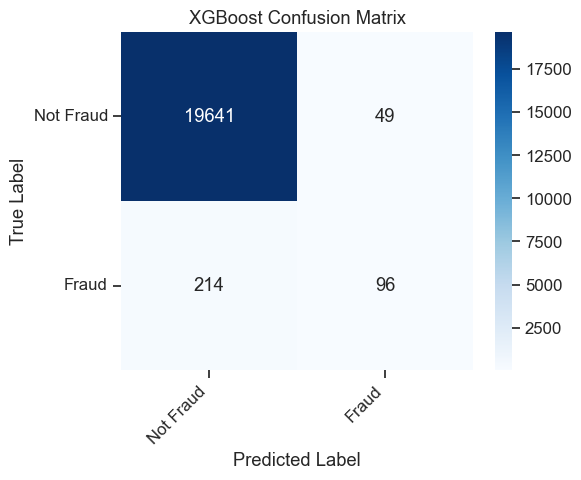

In [4]:
all_results = {} # Dictionary to store results from all models

print(f"Loading XGBoost model from: {xgb_model_path}")
try:
    xgb_model = xgb.Booster()
    xgb_model.load_model(xgb_model_path)

    print("Making XGBoost predictions on test set...")
    dtest_xgb = xgb.DMatrix(X_test_xgb)
    best_iter = getattr(xgb_model, 'best_iteration', 0)
    if best_iter > 0:
         y_pred_proba_xgb = xgb_model.predict(dtest_xgb, iteration_range=(0, best_iter))
    else:
         y_pred_proba_xgb = xgb_model.predict(dtest_xgb)

    # Calculate and store metrics
    xgb_metrics, xgb_cm = calculate_metrics(y_test.values, y_pred_proba_xgb, model_name="XGBoost Baseline")
    all_results["XGBoost Baseline"] = xgb_metrics
    plot_confusion_matrix(xgb_cm, class_names=['Not Fraud', 'Fraud'], title='XGBoost Confusion Matrix')

except xgb.core.XGBoostError as e:
     print(f"Error loading/predicting XGBoost model from {xgb_model_path}: {e}")
except FileNotFoundError:
     print(f"Error: XGBoost model file not found at {xgb_model_path}")
except Exception as e:
     print(f"An unexpected error occurred during XGBoost evaluation: {e}")

## 5. Evaluate GNN Models

In [5]:
#  Helper function for GNN feature pre-calculation (if needed by forward) ---
def precalculate_gnn_features(model, hetero_data, homo_structure, device):
    """Runs FeatureEncoder and constructs x_homo if needed."""
    x_dict_encoded = None
    x_homo = None

    print("  Pre-calculating initial node features using FeatureEncoder...")
    with torch.no_grad():
        x_input_dict = {}
        if 'transaction' in model.node_types:
             x_input_dict['transaction'] = {
                 'x_num': hetero_data['transaction'].x_num if hasattr(hetero_data['transaction'], 'x_num') else None,
                 'x_cat': hetero_data['transaction'].x_cat if hasattr(hetero_data['transaction'], 'x_cat') else None
             }
        for node_type in model.node_types:
             if node_type != 'transaction' and node_type not in x_input_dict:
                  x_input_dict[node_type] = hetero_data[node_type].x if hasattr(hetero_data[node_type], 'x') else None
        # Move inputs to device
        for node_type, features in x_input_dict.items():
             if isinstance(features, dict):
                  for key, tensor in features.items():
                       if tensor is not None: features[key] = tensor.to(device)
             elif features is not None:
                  x_input_dict[node_type] = features.to(device)

        x_dict_encoded = model.feature_encoder(x_input_dict)

    if model.model_type == 'homo':
        if homo_structure is None:
            raise ValueError("homo_structure needed for pre-calculation in homo mode.")
        print("  Constructing x_homo tensor from encoded features...")
        num_total_nodes = homo_structure.node_type.size(0)
        x_homo = torch.zeros((num_total_nodes, model.hidden_channels), device=device)
        node_type_errors = False
        for i, node_type in enumerate(model.node_types):
             node_mask = (homo_structure.node_type == i)
             num_nodes_in_mask = node_mask.sum().item()
             if node_type in x_dict_encoded and x_dict_encoded[node_type] is not None:
                  features = x_dict_encoded[node_type]
                  if features.shape[0] == num_nodes_in_mask:
                       if features.shape[0] > 0: x_homo[node_mask] = features
                  else:
                       print(f"    Error: Shape mismatch for node type '{node_type}'. Encoded: {features.shape}, Mask: {num_nodes_in_mask}")
                       node_type_errors = True
             elif num_nodes_in_mask > 0:
                  print(f"    Warning: No encoded features for node type '{node_type}', using zeros.")
        if node_type_errors: raise ValueError("Shape mismatch constructing x_homo.")
        print(f"    x_homo constructed with shape: {x_homo.shape}")

    return x_dict_encoded, x_homo


===== Evaluating GNN Run: 20250330_162353_homo_SAGE_h128_l3 =====
Metadata[0] detected as flat list of strings.
  FeatureEncoder: Creating transaction categorical embeddings for: ['id_13', 'id_14', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_16', 'id_27', 'id_28', 'id_29', 'id_35', 'id_36', 'id_37', 'id_38', 'ProductCD', 'M4', 'id_15', 'id_34']
    Transaction emb 'id_13': 40 cats -> 19 dims
    Transaction emb 'id_14': 24 cats -> 11 dims
    Transaction emb 'M1': 3 cats -> 2 dims
    Transaction emb 'M2': 4 cats -> 2 dims
    Transaction emb 'M3': 4 cats -> 2 dims
    Transaction emb 'M5': 4 cats -> 2 dims
    Transaction emb 'M6': 4 cats -> 2 dims
    Transaction emb 'M7': 4 cats -> 2 dims
    Transaction emb 'M8': 4 cats -> 2 dims
    Transaction emb 'M9': 4 cats -> 2 dims
    Transaction emb 'id_12': 4 cats -> 2 dims
    Transaction emb 'id_16': 4 cats -> 2 dims
    Transaction emb 'id_27': 4 cats -> 2 dims
    Transaction emb 'id_28': 4 cats -> 2 dims
    Transac

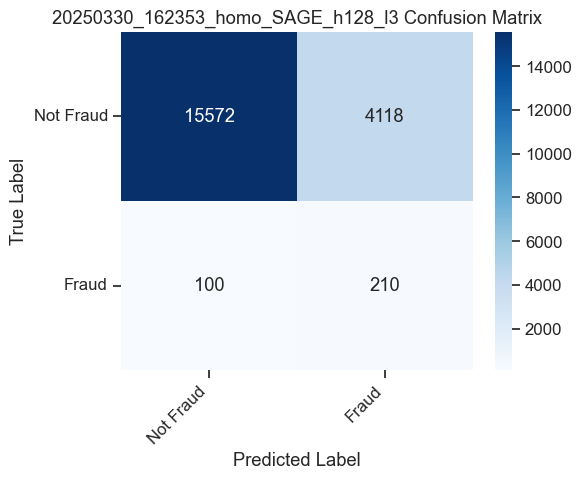


===== Evaluating GNN Run: 20250330_162733_hetero_RGCN_h128_l2 =====
Metadata[0] detected as flat list of strings.
  FeatureEncoder: Creating transaction categorical embeddings for: ['id_13', 'id_14', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_16', 'id_27', 'id_28', 'id_29', 'id_35', 'id_36', 'id_37', 'id_38', 'ProductCD', 'M4', 'id_15', 'id_34']
    Transaction emb 'id_13': 40 cats -> 19 dims
    Transaction emb 'id_14': 24 cats -> 11 dims
    Transaction emb 'M1': 3 cats -> 2 dims
    Transaction emb 'M2': 4 cats -> 2 dims
    Transaction emb 'M3': 4 cats -> 2 dims
    Transaction emb 'M5': 4 cats -> 2 dims
    Transaction emb 'M6': 4 cats -> 2 dims
    Transaction emb 'M7': 4 cats -> 2 dims
    Transaction emb 'M8': 4 cats -> 2 dims
    Transaction emb 'M9': 4 cats -> 2 dims
    Transaction emb 'id_12': 4 cats -> 2 dims
    Transaction emb 'id_16': 4 cats -> 2 dims
    Transaction emb 'id_27': 4 cats -> 2 dims
    Transaction emb 'id_28': 4 cats -> 2 dims
    Trans

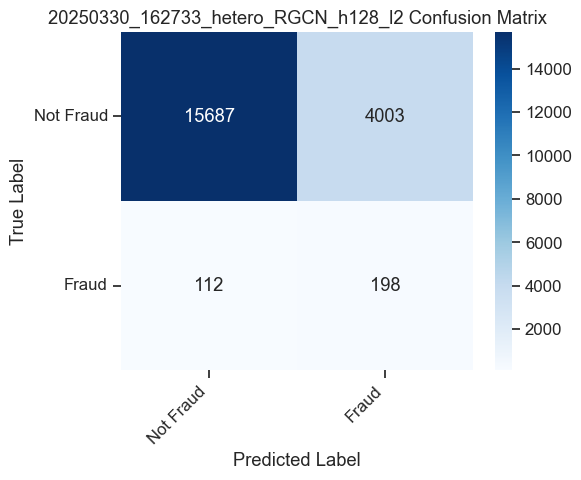


===== Evaluating GNN Run: 20250330_163731_hetero_SAGE_h32_l1 =====
Metadata[0] detected as flat list of strings.
  FeatureEncoder: Creating transaction categorical embeddings for: ['id_13', 'id_14', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_16', 'id_27', 'id_28', 'id_29', 'id_35', 'id_36', 'id_37', 'id_38', 'ProductCD', 'M4', 'id_15', 'id_34']
    Transaction emb 'id_13': 40 cats -> 19 dims
    Transaction emb 'id_14': 24 cats -> 11 dims
    Transaction emb 'M1': 3 cats -> 2 dims
    Transaction emb 'M2': 4 cats -> 2 dims
    Transaction emb 'M3': 4 cats -> 2 dims
    Transaction emb 'M5': 4 cats -> 2 dims
    Transaction emb 'M6': 4 cats -> 2 dims
    Transaction emb 'M7': 4 cats -> 2 dims
    Transaction emb 'M8': 4 cats -> 2 dims
    Transaction emb 'M9': 4 cats -> 2 dims
    Transaction emb 'id_12': 4 cats -> 2 dims
    Transaction emb 'id_16': 4 cats -> 2 dims
    Transaction emb 'id_27': 4 cats -> 2 dims
    Transaction emb 'id_28': 4 cats -> 2 dims
    Transa

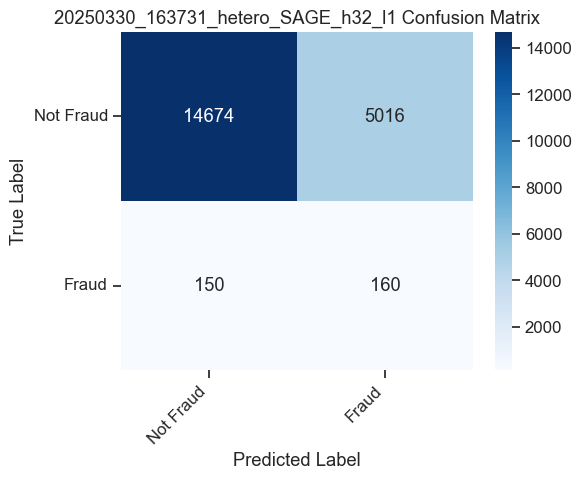

In [6]:
#  Loop through specified GNN run directories --- 
for run_dir in gnn_run_dirs:
    run_name = os.path.basename(run_dir)
    print(f"\n===== Evaluating GNN Run: {run_name} =====")
    config_path = os.path.join(run_dir, "config.json")
    model_path = os.path.join(run_dir, "model_state.pt")

    if not os.path.exists(config_path) or not os.path.exists(model_path):
        print(f"Skipping run {run_name}: Missing config.json or model_state.pt")
        continue

    # Load config and instantiate model
    try:
        with open(config_path, 'r') as f:
            hparams = json.load(f)

        model_type = hparams['model_type']
        conv_type = hparams['conv_type']
        hidden_channels = hparams['hidden_channels']
        num_layers = hparams['num_layers']
        embedding_dim_other = hparams['embedding_dim_other']
        gat_heads = hparams.get('gat_heads', 4)
        num_nodes_dict_loaded = hparams.get('num_nodes_per_type')
        if num_nodes_dict_loaded is None: raise ValueError("'num_nodes_per_type' missing")

        # Get encoder info from loaded processors
        encoder_gnn_info = processors.get('encoder_gnn')
        num_numerical_features = processors.get('num_numerical_features')
        if encoder_gnn_info is None or num_numerical_features is None: raise ValueError("Processor info missing")
        encoder_gnn_info['num_numerical_features'] = num_numerical_features

        # Instantiate model
        model = FraudGNN(
            node_metadata=hetero_data_full.metadata(), # Use metadata from loaded full graph
            num_nodes_dict=num_nodes_dict_loaded,
            encoder_info=encoder_gnn_info,
            hidden_channels=hidden_channels,
            out_channels=2,
            num_layers=num_layers,
            embedding_dim_other=embedding_dim_other,
            model_type=model_type,
            conv_type=conv_type,
            heads=gat_heads
        ).to(device)

        # Load weights
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()

        # Pre-calculate features and convert structure if needed
        homo_data_structure = None
        if model_type == 'homo':
            homo_data_structure = convert_to_homogeneous(hetero_data_full) # Convert full graph structure
            homo_data_structure = homo_data_structure.to(device)

        x_dict_encoded, x_homo = precalculate_gnn_features(model, hetero_data_full, homo_data_structure, device)

        # Perform Inference
        print("  Performing inference...")
        eval_start_time = time.time()
        with torch.no_grad():
            if model_type == 'hetero':
                 out = model(hetero_data_full, x_dict_encoded=x_dict_encoded)
            else: # homo
                 out = model(homo_data_structure, x_homo=x_homo)
        eval_duration = time.time() - eval_start_time
        print(f"  Inference completed in {eval_duration:.2f}s")

        # Extract Test Predictions and Labels
        test_mask = hetero_data_full['transaction'].test_mask
        target = hetero_data_full['transaction'].y
        if test_mask.sum() == 0:
             print("  Error: No nodes found in the test mask. Cannot evaluate.")
             continue # Skip to next model

        test_logits = out[test_mask]
        test_probs = F.softmax(test_logits, dim=1)[:, 1]
        y_test_gnn = target[test_mask]

        # Calculate and store metrics
        gnn_metrics, gnn_cm = calculate_metrics(y_test_gnn.cpu().numpy(), test_probs.cpu().numpy(), model_name=run_name)
        all_results[run_name] = gnn_metrics
        plot_confusion_matrix(gnn_cm, class_names=['Not Fraud', 'Fraud'], title=f'{run_name} Confusion Matrix')

    except Exception as e:
        print(f"!!! Error evaluating run {run_name}: {e} !!!")
        import traceback
        traceback.print_exc() # Print full traceback for debugging
        all_results[run_name] = {} # Add empty entry on error

## 6. Compare Results


===== Overall Comparison =====
                                        AUC      AP  F1_Fraud  F1_Macro  Precision_Fraud  Recall_Fraud   TP    FP   FN     TN
XGBoost Baseline                     0.8735  0.3487    0.4220    0.7077           0.6621        0.3097   96    49  214  19641
20250330_162353_homo_SAGE_h128_l3    0.8151  0.1443    0.0906    0.4856           0.0485        0.6774  210  4118  100  15572
20250330_162733_hetero_RGCN_h128_l2  0.7879  0.1166    0.0878    0.4859           0.0471        0.6387  198  4003  112  15687
20250330_163731_hetero_SAGE_h32_l1   0.6580  0.0463    0.0583    0.4543           0.0309        0.5161  160  5016  150  14674


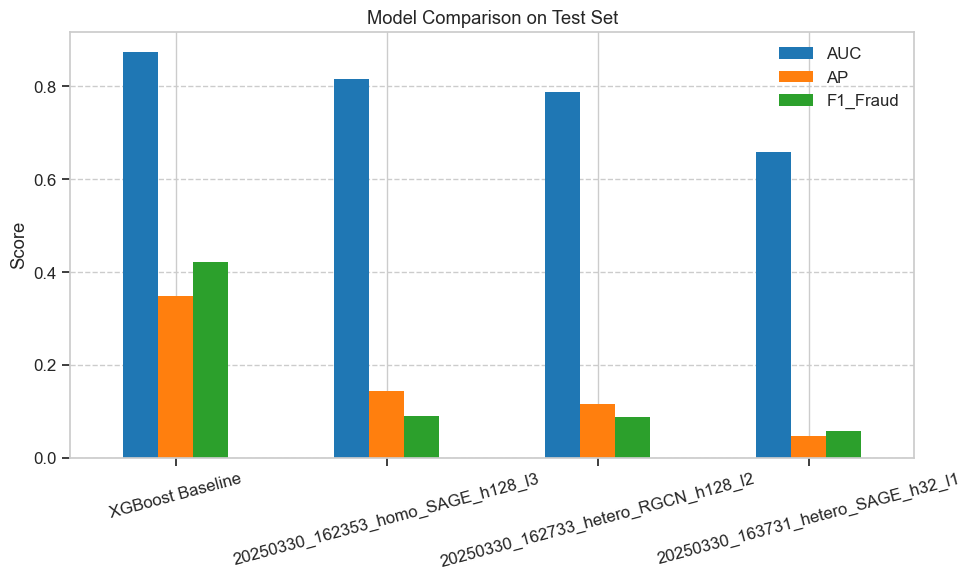

In [7]:
print("\n===== Overall Comparison =====")
results_df = pd.DataFrame.from_dict(all_results, orient='index')

# Select and order columns for display
display_cols = ['AUC', 'AP', 'F1_Fraud', 'F1_Macro', 'Precision_Fraud', 'Recall_Fraud', 'TP', 'FP', 'FN', 'TN']
results_df = results_df[[col for col in display_cols if col in results_df.columns]] # Keep only existing columns

print(results_df.round(4).to_string())

# Optional: Plot key metrics for comparison
metrics_to_plot = ['AUC', 'AP', 'F1_Fraud']
plot_df = results_df[[col for col in metrics_to_plot if col in results_df.columns]].dropna()

if not plot_df.empty:
    plot_df.plot(kind='bar', figsize=(max(10, len(plot_df)*1.5), 6), rot=15, title='Model Comparison on Test Set')
    plt.ylabel('Score')
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

### Evaluation Summary

The evaluation results on the held-out test set reveal significant differences between the XGBoost baseline and the various GNN models tested.

1.  **Overall Performance (AUC & AP):**
    *   The **XGBoost Baseline** clearly performs best overall, achieving a strong **Test AUC of 0.8735** and a **Test Average Precision (AP) of 0.3487**. This indicates good discrimination between classes and relatively good performance on the minority fraud class, which is crucial for imbalanced datasets.
    *   Among the GNNs, the **`homo_SAGE_h128_l3`** model achieved the highest **Test AUC (0.8151)** and **Test AP (0.1443)**. While its AUC is respectable, the AP is considerably lower than XGBoost's, suggesting it struggles more with precision on the fraud class.
    *   The `hetero_RGCN_h128_l2` model performed slightly worse than the best GNN (AUC 0.7879, AP 0.1166).
    *   The simplest GNN tested, `hetero_SAGE_h32_l1`, performed poorly (AUC 0.6580, AP 0.0463), indicating that the minimal architecture was insufficient.

2.  **GNN vs. XGBoost Comparison:**
    *   All tested GNN models underperformed compared to the XGBoost baseline on both AUC and AP metrics.
    *   The gap is particularly large in Average Precision, highlighting that while GNNs might identify *some* fraud patterns (as seen in recall), they generate significantly more false positives than XGBoost at the default 0.5 threshold.

3.  **Precision and Recall (Fraud Class):**
    *   **XGBoost:** Shows moderate **Recall (0.3097)**, meaning it catches about 31% of the actual fraud cases, but has much better **Precision (0.6621)**, meaning when it predicts fraud, it's correct about 66% of the time. This leads to a reasonable **F1-score (0.4220)** for the fraud class. The confusion matrix confirms this: 96 True Positives (TP) vs. only 49 False Positives (FP).
    *   **Best GNN (`homo_SAGE_h128_l3`):** Exhibits very high **Recall (0.6774)**, catching almost 68% of fraud cases (TP=210). However, this comes at the cost of extremely low **Precision (0.0485)**. When this GNN predicts fraud, it's only correct about 5% of the time. This results in a very low **F1-score (0.0906)** for the fraud class. The confusion matrix starkly illustrates this: 210 TPs but a massive 4118 FPs.
    *   **Other GNNs:** Show similar patterns of high recall but very poor precision compared to XGBoost.

### Conclusion:

Based on the test set evaluation, the **XGBoost baseline significantly outperforms all tested GNN configurations** in terms of both overall discriminative power (AUC) and practical effectiveness in identifying fraud with acceptable precision (AP, F1-Fraud).

While the best GNN model (`homo_SAGE_h128_l3`) demonstrated a high capacity to *recall* fraudulent transactions (identifying 68% of them), it did so by incorrectly flagging a very large number of non-fraudulent transactions as fraudulent, resulting in extremely low precision and a poor F1-score for the fraud class. This suggests the GNN models, in their current state and using the default 0.5 classification threshold, are not practically useful as they generate too many false alarms compared to the baseline.

The substantial performance gap between the GNNs' validation results (previously noted as 0.82-0.85 AUC) and their test results (0.65-0.81 AUC), combined with the poor precision on the test set, strongly reinforces the earlier conclusion that **concept drift** significantly impacts the GNNs' ability to generalize. The patterns learned from earlier data seem insufficient or misleading for classifying transactions in the later test period. While XGBoost also faces this challenge, its feature representation and learning mechanism appear more robust to the observed temporal shifts in this dataset. Further improvements for the GNN would require addressing this drift, potentially through advanced feature engineering, temporal graph methods, or adaptive retraining strategies.